In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
from generation import FiguresDataset, id_to_cname, SIZE
from process import show_img, pick, sample

In fact we can't use typical augmentations (rotate, shift, crop) on those images (despite their symmetry is inductive bias) cause that would impact labels (bounding boxes)

In [13]:
from torchvision import transforms as T
tr = T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0, 0, 0], std=[0.5, 0.5, 0.5]),
    # T.ColorJitter(
    #         brightness=0.5, contrast=0.5,
    #         saturation=0.5, hue=0.5
    #     ),
    T.Resize(416, antialias=True),
])

In [14]:
ds = FiguresDataset(transforms=tr)

10000 images and their descriptions have been loaded successfully


We've casted our dataset to torch.float tensors scaled to $[0,1]$ and normalized (sub mean div std), and their labels - list of tuples $(shape, xcenter, ycenter, width, height)$

In [15]:
ds[0][0].dtype, ds[0][1], id_to_cname

(torch.float32,
 [(4, 315.25, 234.0, 46.637499999999996, 46.637499999999996),
  (1, 68.25, 97.5, 90.77483303482303, 90.77483303482303),
  (0, 177.125, 234.0, 52.86899629548219, 52.86899629548219)],
 ['Circle', 'Rhombus', 'Rectangle', 'Triangle', 'Hexagon'])

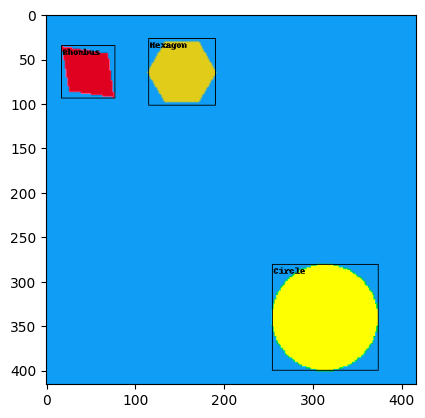

(None,
 [(4, 152.75, 65.0, 75.07499999999999, 75.07499999999999),
  (1, 47.125, 65.0, 59.750523010263265, 59.750523010263265),
  (0, 313.625, 341.25, 118.96171130649577, 118.96171130649577)])

In [16]:
show_img(pick(ds[666])), ds[666][1]

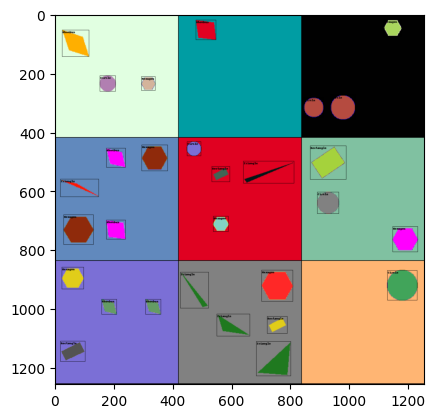

In [17]:
sample(ds)

I am going to implement YOLOv3 

YOLO is an agorithm that processes whole image in 1-pass manner using just convolutions

Our feature detector is somewhat typical, i.e. we stick to 75 convolutional layers only, so that is FCN (but with bells and whistles) and it outputs some feature map

But the classifier/regressor is 1x1 convolution over feature map, result is called cell map (same size) 

Each cell has to predict ONE object (=one of its bboxes) if its center falls into receiptive field

Suppose that a cell can predict a fixed amount of bounding boxes (let it be B=3 for v3) and each of those tends to 'specialize' in detecting particular object

Condition of each bbox is described by $5+C$ parameters:

- cx, cy - minimal vertex, pw, ph - dimensions for bounding box --> 4
- o - objectness score (confidence t) --> 1
- all class scores (conditional probability, implying o) --> C (number of classes, we have 5 figures)

And, therefore our feature detector should output a 3-tensor
$$C*H*W \rightarrow S*S*(B*(5+C))$$
where H=W and divisible by S

How to train:
let's create an S-grid on original image and match 1:1 to the cells from output
$$inp.cells \Leftrightarrow out.cells$$
Say, ic contains center of object's bbox, then corresponding oc is responsible for its detection

But which one of 3 boxes predicts ground truth?

in fact, we don't output xywh boxes directly, instead we state 3 fixed 'anchors' i.e. boxes $[cx,cy, pw, ph]$ controlled by 4 parameters $[tx,ty,tw,th]$ to fit ground truth bbox, aka log-space transform

\begin{split}
x = \sigma(tx) + cx\\
y = \sigma(ty) + cy\\
w = pw*e^{tw}\\
h = ph*e^{th}
\end{split}

So, we choose an anchor with a highest IoU (with gt box), then tune up its parameters to get a better fit